# Explore Concepts needed for Lighting Controller

In [14]:
%matplotlib inline

import numpy as np
from PIL import Image, ImageDraw, ImageColor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import HTML
from IPython.display import Image as disp_Image
import colorsys

In [36]:
def display_images( images=None, ms=50, loop=10 ):
     """
     Animate a list of images by creating a GIF file
     then displaying the resulting GIF file
     """

     # Save options
     save_opts = { 'fp':'dev_animated_image.png', 'format':'GIF' }

     # Get the first image and setup for any remaining images
     try:
          first_img = images[0]
          SAVE_MULTI_OPTS = { 'append_images':images[1:], 'save_all':True, 'duration':ms, 'loop':loop }
          save_opts.update(SAVE_MULTI_OPTS)

     except TypeError:
          first_img = images

     # Save the image to a temp file
     first_img.save(**save_opts)

     # Display the GIF from the temp file
     display( HTML(f'<img src=\"{save_opts["fp"]}\">') )

In [6]:
class Model():
    """
    Class representing the sides and top of the model and their LEDs
    """
    def __init__(self):

        # Model Configuration
        self.MODEL_INTERIOR_COLOR = 'rgb(128,128,128)'
        self.MODEL_OUTLINE_COLOR = 'rgb(0,0,0)'
        self.MODEL_CONFIG = {
            'Left': {
                'bbox': (0,200, 200,400),
                'leds': { 'rows': 5, 'cols': 6 }
                },

            'Right': {
                'bbox': (400,200, 600,400),
                'leds': { 'rows': 5, 'cols': 6 }
                },

            'Top': {
                'bbox': (200,0, 400,200),
                'leds': { 'rows': 2, 'cols': 3 }
                }
        }

        # Model image
        self.model = None


    def draw_model_sides_top(self):
        """
        Draw the main components of the model: sides, top
        """
        # Create background enclosure for the model
        self.model = Image.new( "RGB", (600,400), color=(10,10,10) )

        # Prepare to draw objects
        model_draw = ImageDraw.Draw(self.model)

        for c in self.MODEL_CONFIG:
            model_draw.rectangle( self.MODEL_CONFIG[c]['bbox'], fill=self.MODEL_INTERIOR_COLOR, outline=self.MODEL_OUTLINE_COLOR )

    @staticmethod
    def rgb_to_string( rgb:tuple ) -> str:
        r, g, b = rgb
        return f"rgb({r},{g},{b})"


    def draw_model_leds(self, led_colors:dict=None ):
        """
        Draw LEDs on the model based upon the configurations
        of the model
        @TODO: and the color for each LED
        """

        # Prepare to draw objects
        model_draw = ImageDraw.Draw(self.model)

        # LEDs
        def _draw_led( xy, color='rgb(0,0,0)' ):
            """
            Draw one LED
            """
            LED_RADIUS = 5
            model_draw.ellipse( [ (xy[0]-LED_RADIUS,xy[1]-LED_RADIUS), (xy[0]+LED_RADIUS,xy[1]+LED_RADIUS)], fill=color, outline='rgb(0,0,0)' )

        for c in self.MODEL_CONFIG:

            # Determine the width and height of this component
            bbox = self.MODEL_CONFIG[c]['bbox']
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]

            # How many columns and rows of LEDs need to fit in this space
            n_cols = self.MODEL_CONFIG[c]['leds']['cols']
            n_rows = self.MODEL_CONFIG[c]['leds']['rows']

            # Determine the number of pixels per LED,
            # Adding 2 to the count so that LEDs will not be placed on an edge
            pix_per_col = w // (n_cols + 1)
            pix_per_row = h // (n_rows + 1)
            # print(c, bbox, w, h, n_cols, n_rows, pix_per_col, pix_per_row)

            # Draw the LEDs, starting with index 1 (to avoid an edge)
            for col in range(1,n_cols+1):
                for row in range(1, n_rows+1):

                    # Draw the LED using the specified color
                    if led_colors:
                        _draw_led( ( pix_per_col*col + bbox[0], pix_per_row*row + bbox[1] ), color=led_colors[c][row-1][col-1] )
                    else:
                        _draw_led( ( pix_per_col*col + bbox[0], pix_per_row*row + bbox[1] ) )

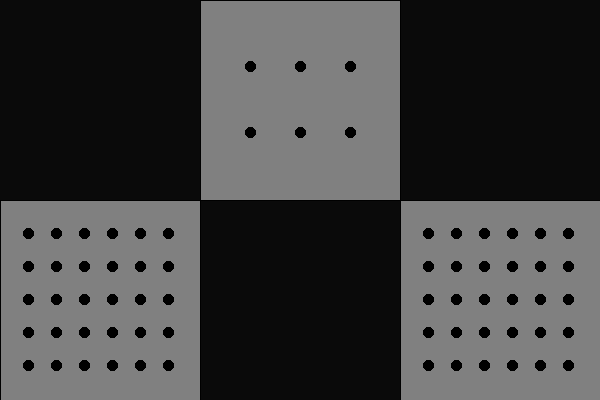

In [7]:

# Create a model
m = Model()

# Draw the sides and top of the model
m.draw_model_sides_top()

# Draw LEDs with default color
m.draw_model_leds()

# Display the model
display( m.model )

In [32]:
# Create arrays representing the LED colors
def fill_leds( rgb:tuple ):
    led_cols = {}
    for c in m.MODEL_CONFIG:
        led_cols[c] = np.full( (m.MODEL_CONFIG[c]['leds']['rows'], m.MODEL_CONFIG[c]['leds']['cols']), fill_value=Model.rgb_to_string( rgb ) ) 
        # print( c, (m.MODEL_CONFIG[c]['leds']['rows'], m.MODEL_CONFIG[c]['leds']['cols']), '=>', led_cols[c].shape )

    return led_cols


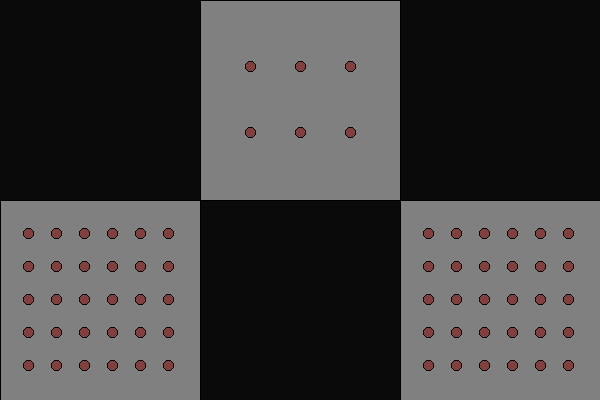

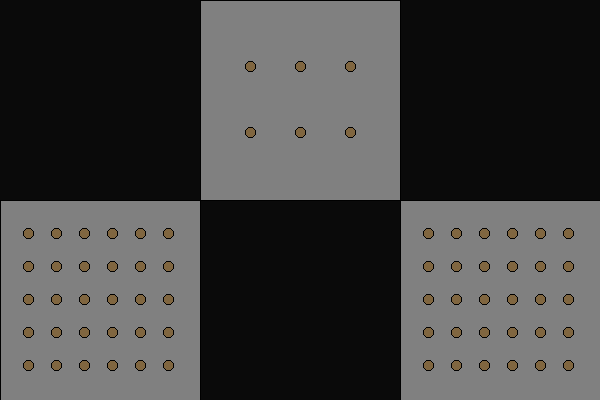

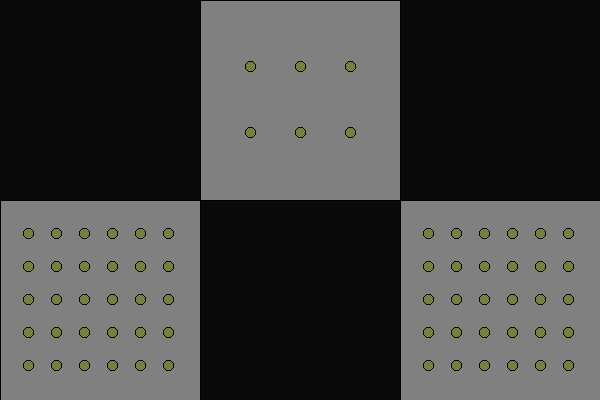

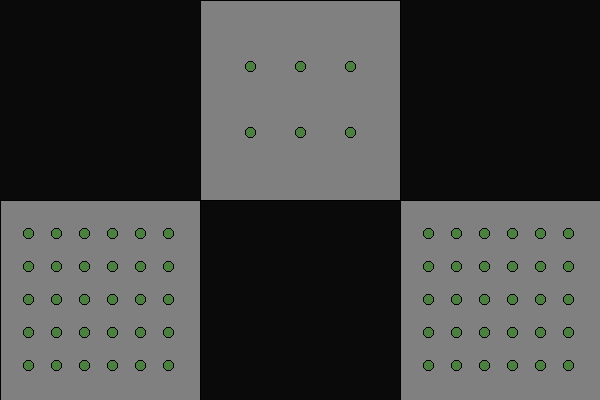

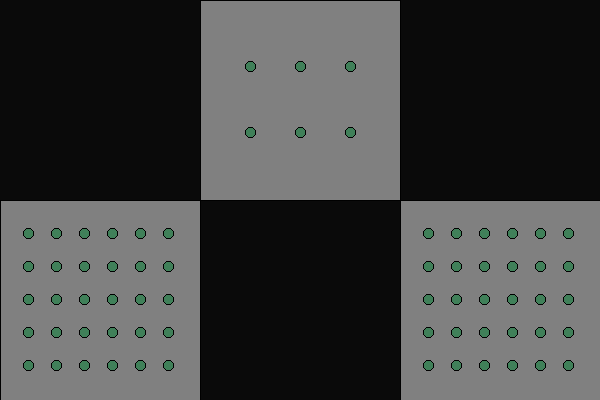

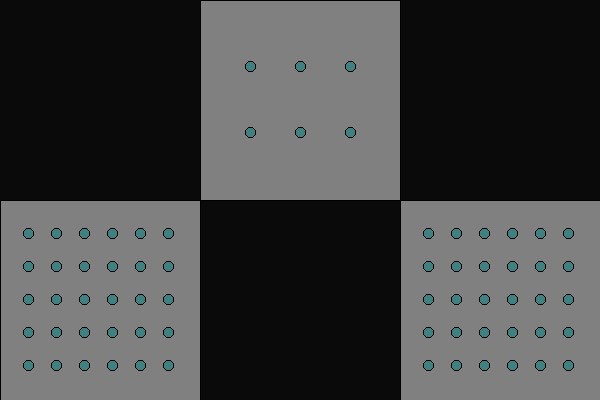

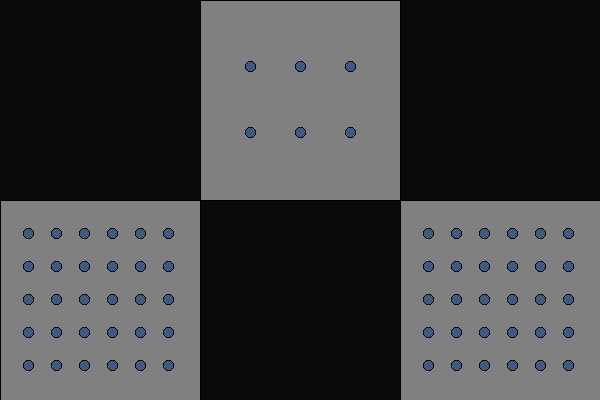

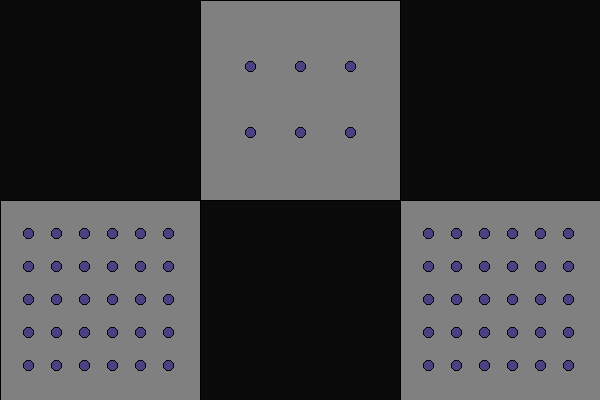

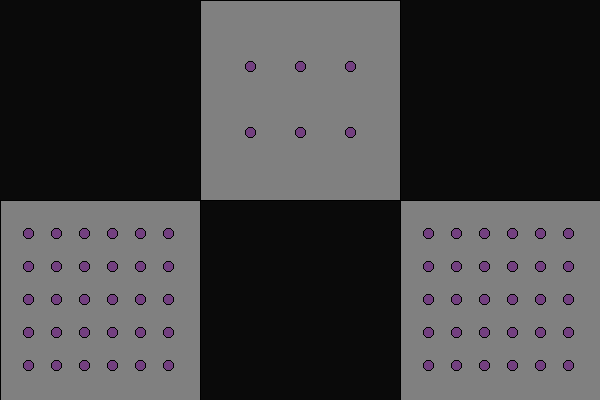

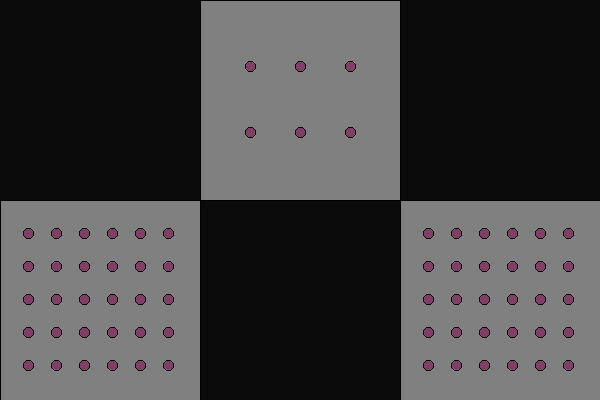

In [39]:
# Draw and display the resulting model
images = []
for h in np.arange(0, 1.0, 0.1):
    lc = fill_leds( [ int(256*x) for x in colorsys.hsv_to_rgb(h,0.5,0.5) ] )
    m.draw_model_leds( lc )
    images.append( m.model )
    display( m.model )

display_images( images )

In [35]:
len(images)

10